In [1]:
# Import Dependencies
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import csv

In [2]:
# Load csv into DataFrame
df_earthquakes = pd.read_csv("Resources/eq_data.csv")

In [3]:
# Load the CSV file into a list of tuples
data = []
with open("Resources/eq_data.csv") as f:
    reader = csv.reader(f)
    header = next(reader)
    for row in reader:
        data.append(tuple(row))

In [4]:
df_earthquakes.id.nunique()

7449

In [5]:
# Connect to/Create database
conn = sqlite3.connect("Resources/earthquakes.sqlite")

In [6]:
# Create eq_data table

query = """
    CREATE Table IF NOT EXISTS eq_data
    (
        index_id INTEGER PRIMARY KEY AUTOINCREMENT,
        time TEXT,
        latitude REAL,
        longitude REAL,
        depth REAL,
        mag REAL,
        magType TEXT,
        nst INTEGER,
        gap REAL,
        dmin REAL,
        rms REAL,
        net TEXT,
        id TEXT,
        updated TEXT,
        place TEXT,
        type TEXT,
        horizontalError REAL,
        depthError REAL,
        magError REAL,
        magNst INTEGER,
        status TEXT,
        locationSource TEXT,
        magSource TEXT
    );
"""

conn = sqlite3.connect("Resources/earthquakes.sqlite")
conn.execute(query)
conn.commit()

In [7]:
# Insert data from tuples (from csv) into eq_data table)
insert_query = """
    INSERT INTO eq_data (time, latitude, longitude, depth, mag, magType, nst, gap, dmin, rms, net, id, updated, place, type,
                            horizontalError, depthError, magError, magNst, status, locationSource, magSource)
                            VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """
conn.executemany(insert_query, data)
conn.commit()

In [8]:
# Load SELECT data into DataFrame
df_magnitude_by_magType = pd.read_sql_query("SELECT mag, magType FROM eq_data", conn)
df_magnitude_by_magType

,mag,magType
0,4.14,mw
1,3.47,mw
2,3.34,mw
3,3.01,ml
4,3.57,mw
...,...,...
14893,3.85,mw
14894,3.49,ml
14895,3.14,ml
14896,3.11,md


In [9]:
# Load SELECT data into DataFrame
df_magnitude_by_time = pd.read_sql_query("SELECT time, mag FROM eq_data", conn)
df_magnitude_by_time


,time,mag
0,2022-12-31T12:12:26.650Z,4.14
1,2022-12-31T11:41:09.460Z,3.47
2,2022-12-22T02:22:50.250Z,3.34
3,2022-12-20T15:30:01.280Z,3.01
4,2022-12-17T11:39:42.860Z,3.57
...,...,...
14893,2000-01-06T21:38:10.940Z,3.85
14894,2000-01-03T21:59:31.780Z,3.49
14895,2000-01-02T17:58:32.820Z,3.14
14896,2000-01-02T15:49:40.650Z,3.11


In [10]:
# Create a new dataframe with the converted date column
df_converted_mag_by_year = df_magnitude_by_time.copy()
df_converted_mag_by_year['year'] = pd.to_datetime(df_converted_mag_by_year['time'], format='%Y-%m-%dT%H:%M:%S.%fZ').dt.year
df_converted_mag_by_year

,time,mag,year
0,2022-12-31T12:12:26.650Z,4.14,2022
1,2022-12-31T11:41:09.460Z,3.47,2022
2,2022-12-22T02:22:50.250Z,3.34,2022
3,2022-12-20T15:30:01.280Z,3.01,2022
4,2022-12-17T11:39:42.860Z,3.57,2022
...,...,...,...
14893,2000-01-06T21:38:10.940Z,3.85,2000
14894,2000-01-03T21:59:31.780Z,3.49,2000
14895,2000-01-02T17:58:32.820Z,3.14,2000
14896,2000-01-02T15:49:40.650Z,3.11,2000


In [11]:
# Data types
check_dt = df_converted_mag_by_year.dtypes
print(check_dt)

time     object
mag     float64
year      int64
dtype: object


In [12]:
df_mag_year = pd.DataFrame(df_converted_mag_by_year.groupby(["year"])["mag"].mean())
df_mag_year

,mag
year,
2000,3.357956
2001,3.344212
2002,3.339188
2003,3.414804
2004,3.404423
2005,3.438697
2006,3.392437
2007,3.413061
2008,3.413532


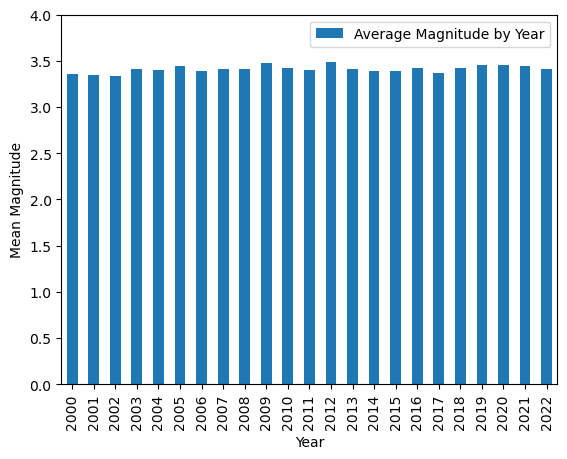

In [13]:
# Plot the mean magnitude by magnitude type
df_mag_year.plot(kind="bar")

# Label x and y axis
plt.xlabel("Year")
plt.ylabel("Mean Magnitude")
plt.yticks([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
plt.legend(["Average Magnitude by Year"])

# Show the plot
plt.show()

In [14]:
df_mag_count = pd.DataFrame(df_converted_mag_by_year.groupby(["year"])["mag"].count())
df_mag_count

,mag
year,
2000,636
2001,622
2002,394
2003,816
2004,728
2005,522
2006,394
2007,392
2008,402


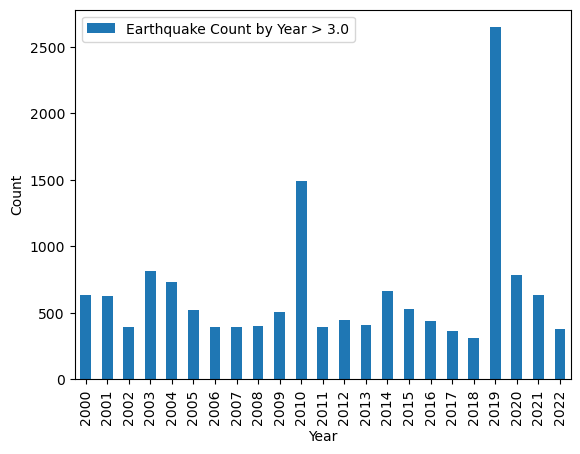

In [15]:
# Plot the count of magnitude 3.0 tremor by year
df_mag_count.plot(kind="bar")

# Label x and y axis
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(["Earthquake Count by Year > 3.0"])

# Show the plot
plt.show()

In [16]:
# Close the database
conn.close()